In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('E:\data_for_tree.csv'))

Memory usage of dataframe is 61303462.00 MB
Memory usage after optimization is: 16520197.00 MB
Decreased by 73.1%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [5]:
#线性回归 & 五折交叉验证 & 模拟真实业务情况
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

#简单建模
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

In [6]:
#查看训练的线性回归模型的截距（intercept）与权重(coef)
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641876),
 ('v_8', 700675.5609398839),
 ('v_9', 170630.2772321982),
 ('v_7', 32322.661932023675),
 ('v_12', 20473.670797002425),
 ('v_3', 17868.07954151805),
 ('v_11', 11474.938996721747),
 ('v_13', 11261.76456002129),
 ('v_10', 2683.9200906181904),
 ('gearbox', 881.822503924847),
 ('fuelType', 363.9042507216654),
 ('bodyType', 189.60271012070453),
 ('city', 44.94975120521693),
 ('power', 28.55390161675267),
 ('brand_price_median', 0.5103728134078439),
 ('brand_price_std', 0.45036347092627177),
 ('brand_amount', 0.14881120395065228),
 ('brand_price_max', 0.0031910186703147624),
 ('SaleID', 5.355989919855509e-05),
 ('seller', 1.0784773621708155e-05),
 ('train', 7.278053089976311e-06),
 ('offerType', -2.080050762742758e-06),
 ('brand_price_sum', -2.175006868187532e-05),
 ('name', -0.00029800127130351486),
 ('used_time', -0.002515894332894007),
 ('brand_price_average', -0.4049048451010817),
 ('brand_price_min', -2.246775348689306),
 ('power_bin', -34.42064411727807),
 (

The predicted price is obvious different from true price


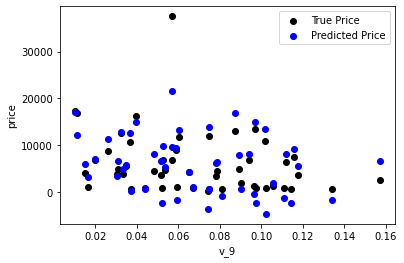

In [7]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
#绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

In [8]:
#通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。
#原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。

It is clear to see the price shows a typical exponential distribution


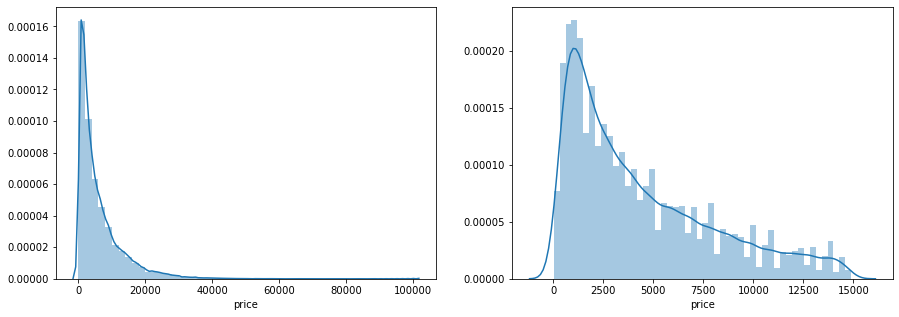

In [9]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [10]:
#在这里我们对标签进行了 log(x+1) 变换，使标签贴近于正态分布
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


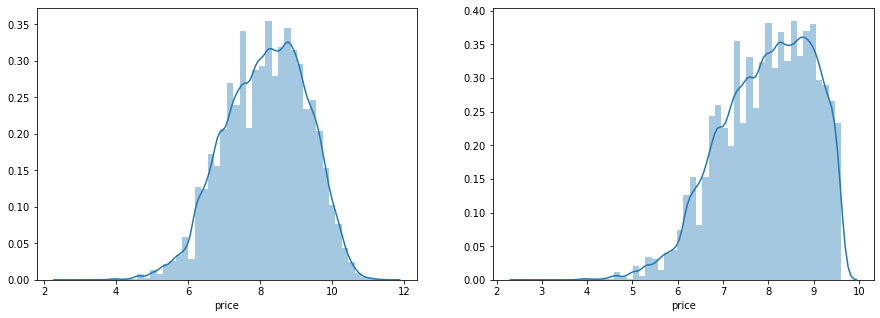

In [11]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [12]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074946553542


[('v_9', 8.052409900567833),
 ('v_5', 5.764236596652335),
 ('v_12', 1.618208123681877),
 ('v_1', 1.479831058299552),
 ('v_11', 1.1669016563613375),
 ('v_13', 0.9404711296038307),
 ('v_7', 0.7137273083564097),
 ('v_3', 0.6837875771098155),
 ('v_0', 0.008500518010251366),
 ('power_bin', 0.008497969302894285),
 ('gearbox', 0.007922377278336584),
 ('fuelType', 0.006684769706827272),
 ('bodyType', 0.004523520092704404),
 ('power', 0.0007161894205355514),
 ('brand_price_min', 3.334351114750296e-05),
 ('brand_amount', 2.8978797042772033e-06),
 ('brand_price_median', 1.2571172873055239e-06),
 ('brand_price_std', 6.659176363447273e-07),
 ('brand_price_max', 6.194956307516704e-07),
 ('brand_price_average', 5.999345965000352e-07),
 ('SaleID', 2.11941700396461e-08),
 ('seller', 2.0081358798051951e-10),
 ('train', 3.05107050735387e-11),
 ('offerType', -1.4312107055047818e-11),
 ('brand_price_sum', -1.512650421591577e-10),
 ('name', -7.015512588894917e-08),
 ('used_time', -4.122479372350924e-06),
 (

The predicted price seems normal after np.log transforming


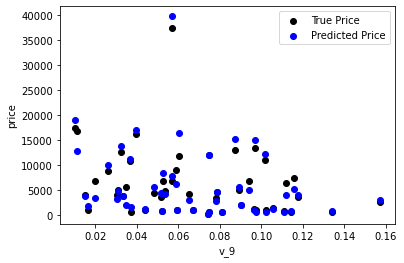

In [13]:
#再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [14]:
#五折交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [15]:
#使用线性回归模型，对未处理标签的特征数据进行五折交叉验证
print('AVG:', np.mean(scores))

AVG: 1.365802392031431


In [16]:
#使用线性回归模型，对处理过标签的特征数据进行五折交叉验证
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AVG: 0.19325301837047398


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [17]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [18]:
#模拟真实业务情况
#但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。
#通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。
#在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

#这个数据集就是按时间采集的
train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301044

<module 'matplotlib.pyplot' from 'C:\\Users\\Administrator.RPK-20180123GWR\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

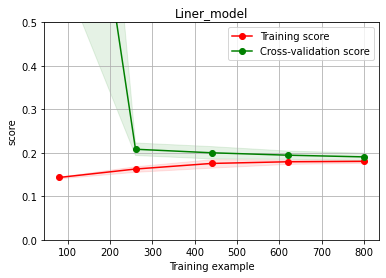

In [20]:
#绘制学习率曲线与验证曲线
from sklearn.model_selection import learning_curve, validation_curve
? learning_curve
#可调用学习率函数，只需要作调整的是误差评价方式
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt

plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)

In [21]:
#多种模型对比
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

#在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。
#而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。
#在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

from sklearn.linear_model import LinearRegression  #普通的线性回归
from sklearn.linear_model import Ridge #岭回归，采用L2范式
from sklearn.linear_model import Lasso  #Lasso回归，采用L1范式

models = [LinearRegression(),
          Ridge(),
          Lasso()]
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [22]:
#三种方法效果的对比
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.75065562245739


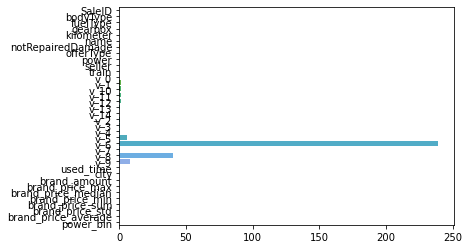

In [23]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [24]:
#L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。
#因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。
#可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；
#但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』



intercept:4.671709788685003


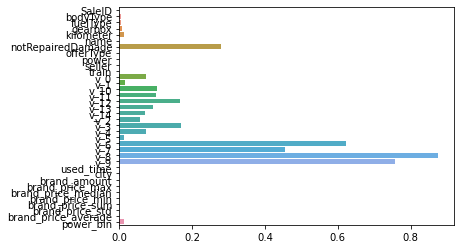

In [25]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182402894256


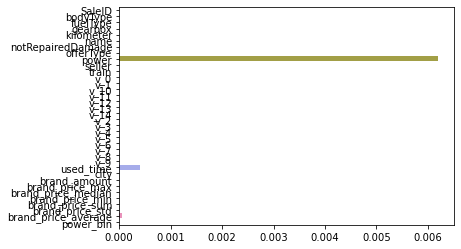

In [26]:
#L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [27]:
#除了线性模型以外，还有许多我们常用的非线性模型如下，我们选择了部分常用模型与线性模型进行效果比对
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
#from lightgbm.sklearn import LGBMRegressor，这个装不了，但目前比较流行，效果也是最好的

models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=10), 
          XGBRegressor(n_estimators = 10, objective='reg:squarederror'), 
          ]#lgb模型对应的是LGBMRegressor(n_estimators = 100)

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished


In [28]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result
#可以看到随机森林模型在每一个fold中均取得了更好的效果

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
cv1,0.190792,0.199425,0.132327,0.168903,524.213869,0.138546
cv2,0.193758,0.194418,0.134472,0.171831,264.191743,0.140402
cv3,0.194132,0.188713,0.133475,0.170931,574.199163,0.139566
cv4,0.191825,0.189352,0.132691,0.169076,385.735180,0.138210
cv5,0.195758,0.203713,0.137248,0.174078,378.425909,0.144279


In [ ]:
#模型调参
#贪心算法 https://www.jianshu.com/p/ab89df9759c8
#网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
#贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [ ]:
#贝叶斯调参
from bayes_opt import BayesianOptimization
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)
rf_bo.maximize()